In [465]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%precision 3

'%.3f'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 4, 4)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [5]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)

In [6]:
tetrode_info = (
    make_tetrode_dataframe(ANIMALS)
    .loc[epoch_key]
    .set_index(['animal', 'day', 'epoch', 'tetrode_number'],
               drop=False))
tetrode_info

animal       area  day    depth descrip  \
animal day epoch tetrode_number                                           
bon    4   4     1                 bon        CA3    4  [[149]]     NaN   
                 2                 bon        CA3    4  [[151]]     NaN   
                 3                 bon        CA1    4  [[100]]     NaN   
                 4                 bon        CA1    4  [[107]]     NaN   
                 5                 bon        CA1    4  [[105]]     NaN   
                 6                 bon        NaN    4    [[0]]     NaN   
                 7                 bon        CA3    4  [[162]]     NaN   
                 8                 bon        CA3    4  [[154]]     NaN   
                 9                 bon        NaN    4      NaN     NaN   
                 10                bon        CA3    4  [[146]]     NaN   
                 11                bon        CA1    4   [[96]]     NaN   
                 12                bon        CA1    4  [[136]]     NaN   
                 13                bon        CA1    4   [[94]]     NaN   
                 14                bon        CA1    4   [[96]]     NaN   
                 15                bon        NaN    4    [[0]]     NaN   
                 16                bon        NaN    4      NaN     NaN   
                 17                bon        CA1    4  [[108]]     NaN   
                 18                bon        CA3    4  [[138]]     NaN   
                 19                bon        CA3    4  [[130]]     NaN   
                 20                bon        CA3    4  [[132]]     NaN   
                 21                bon        CA3    4  [[147]]     NaN   
                 22                bon        CA3    4  [[171]]     NaN   
                 23                bon        CA3    4  [[152]]     NaN   
                 24                bon        CA1    4  [[109]]     NaN   
                 25                bon        CA3    4  [[144]]     NaN   
                 26                bon        NaN    4      NaN     NaN   
                 27                bon        CA3    4  [[158]]     NaN   
                 28                bon        CA1    4  [[103]]     NaN   
                 29                bon        CA1    4  [[118]]     NaN   
                 30                bon  Reference    4    [[0]]     NaN   

                                 epoch hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                                 
bon    4   4     1                   4      right      1.0      0.0      10.0   
                 2                   4      right      NaN      0.0       5.0   
                 3                   4      right      NaN      0.0       0.0   
                 4                   4      right      NaN      0.0       2.0   
                 5                   4      right      NaN      0.0       5.0   
                 6                   4        NaN      NaN      NaN       0.0   
                 7                   4      right      NaN      0.0       2.0   
                 8                   4      right      NaN      0.0       0.0   
                 9                   4        NaN      NaN      NaN       NaN   
                 10                  4      right      NaN      0.0       4.0   
                 11                  4      right      NaN      0.0       6.0   
                 12                  4       left      NaN      0.0       4.0   
                 13                  4       left      NaN      0.0       4.0   
                 14                  4       left      1.0      0.0       8.0   
                 15                  4        NaN      NaN      NaN       0.0   
                 16                  4        NaN      NaN      NaN       NaN   
                 17                  4       left      NaN      0.0       2.0   
                 18                  4       left      NaN      0.0       7.0   
           

In [7]:
from src.data_processing import get_linear_position_structure

mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1', 'CA3']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False) &
    tetrode_info.numcells > 0]

def millisecond_time(epoch_key, animals):
    '''Convert position timestamps to milliseconds to match xinyi'''
    position_time = get_linear_position_structure(epoch_key, animals).index
    start_time, end_time = position_time.min(), position_time.max()
    new_time = np.arange(np.round(start_time * 1E3), np.round(end_time * 1E3)) / 1E3
    return pd.Index(new_time, name='time')
            
position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS, time_function=millisecond_time)

marks = [(get_mark_indicator_dataframe(tetrode_key, ANIMALS, time_function=millisecond_time)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

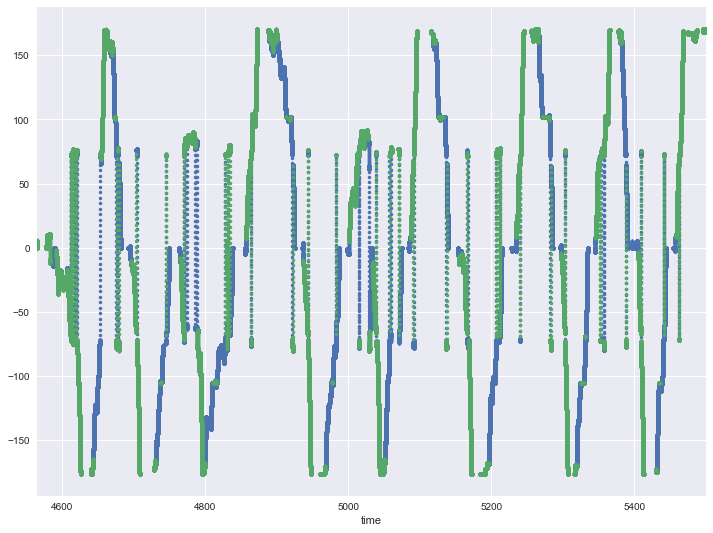

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12, 9))

position_info.linear_position.loc[
    (position_info.trajectory_direction == 'Inbound') &
    (position_info.speed > 4)
].plot(linestyle='None', marker='.', ax=ax);

position_info.linear_position.loc[
    (position_info.trajectory_direction == 'Outbound') &
    (position_info.speed > 4)
].plot(linestyle='None', marker='.', ax=ax);

In [339]:
position = position_info.loc[position_info.speed > 4].linear_position.values
spike_marks = np.stack([m.loc[position_info.speed > 4] for m in marks], axis=0)
trajectory_direction = position_info.loc[position_info.speed > 4].trajectory_direction.values

In [340]:
from src.ripple_decoding import ClusterlessDecoder

decoder = ClusterlessDecoder(
    position, trajectory_direction, spike_marks,
    replay_speedup_factor=33,
    n_position_bins=61
)
decoder.fit();

INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...


In [401]:
from src.data_processing import get_LFP_dataframe
from src.ripple_detection import Kay_ripple_detector

is_hippocampal = (tetrode_info.area.isin(['CA1']) &
                  ~tetrode_info.descrip.str.endswith('Ref').fillna(False) &
                  tetrode_info.validripple == 1)
tetrode_keys = tetrode_info[is_hippocampal].index.tolist()
hippocampus_lfps = pd.concat(
        [get_LFP_dataframe(tetrode_key, ANIMALS)
         for tetrode_key in tetrode_keys], axis=1)
speed = get_interpolated_position_dataframe(
        epoch_key, ANIMALS).speed.values
time = hippocampus_lfps.index.values
ripple_times = Kay_ripple_detector(time, hippocampus_lfps.values, speed, SAMPLING_FREQUENCY,
                                        zscore_threshold=2.0)

In [402]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(
        marks, ripple_times.values, SAMPLING_FREQUENCY)

In [403]:
results = [decoder.predict(ripple_marks, time)
           for ripple_marks, time in test_marks]

In [129]:
from src.analysis import _ripple_session_time
ripple_times['predicted_state'] = [result.predicted_state() for result in results]
ripple_times['predicted_state_probability'] = [result.predicted_state_probability() for result in results]
ripple_times = pd.concat(
    (ripple_times,
     ripple_times.predicted_state.str.split('-', expand=True).rename(columns={0: 'replay_context', 1: 'replay_direction'})),
    axis=1
)
ripple_times['session_time'] = _ripple_session_time(ripple_times, position_info.index)
ripple_times['animal'], ripple_times['day'], ripple_times['epoch'] = epoch_key

In [72]:
(ripple_times.query('predicted_state_probability >= 0.9').predicted_state.value_counts() /
 ripple_times.shape[0]) * 100

Outbound-Reverse    5.269187
Inbound-Forward     1.260023
Outbound-Forward    0.229095
Inbound-Reverse     0.229095
Name: predicted_state, dtype: float64